In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
df_cur = pd.read_csv('data/cust.csv')
df_cur['BE_SEGMENT'] = df_cur['BE_SEGMENT'].str[0].fillna(-1).astype('int')
df_prev = pd.read_csv('data/cust_prev.csv')

df_comb = df_prev.merge(df_cur, on='id', suffixes=['_prev', '_cur'], how='outer')
df_comb = df_comb[df_comb['BE_SEGMENT_prev'] != -1]
df_comb['be_segment_p1m'] = df_comb['BE_SEGMENT_cur']

df_comb['is_affluent_prev'] = (df_comb['BE_SEGMENT_prev'] <= 2).astype(int)
df_comb['is_affluent_cur'] = (df_comb['BE_SEGMENT_cur'] <= 2).astype(int)
df_comb = df_comb[df_comb['is_affluent_prev'] == 0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_reg = df_comb[['id', 'is_affluent_cur']]
df_reg = df_reg.drop_duplicates('id')

train = pd.read_csv('data/model/train.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
val = pd.read_csv('data/model/validate.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)
test = pd.read_csv('data/model/test.csv')[['id', 't1']].rename({'t1': 'is_affluent_cur'}, axis=1)

train_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in train['id']]
val_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in val['id']]
test_idxs = [np.where(df_reg['id'] == cid)[0][0] for cid in test['id']]

In [4]:
del df_comb

# Transactions 

In [5]:
fname = 'data/creditcard_txn.csv'
col_date = 'TRANSACTION_DATE'
col_amt = 'TRANSACTION_AMT'
col_mult = 'D_TRAN_TYPE'

In [6]:
df_saving = pd.read_csv(fname)
df_saving = df_saving[df_saving['Product'] == 'Credit Card']

tmp = set(df_reg['id'])
df_saving = df_saving[[cid in tmp for cid in df_saving['id']]]

df_saving['day'] = pd.to_datetime(df_saving[col_date])

df_saving['transact_d'] = df_saving['transact_c'] = df_saving[col_amt]
df_saving.loc[df_saving[col_mult] == 'C', 'transact_d'] = 0
df_saving.loc[df_saving[col_mult] == 'D', 'transact_c'] = 0
df_saving = df_saving[['id', 'day', 'transact_c', 'transact_d']]

In [7]:
placeholders = []
for cid in df_reg['id']:
    tmp = pd.date_range(start='1/1/2021', end='31/12/2021')
    tmp = pd.DataFrame({'day': tmp, 'transact_c': 0, 'transact_d': 0})
    tmp.insert(0, 'id', cid)
    placeholders.append(tmp)
df_saving = df_saving.append(pd.concat(placeholders))

df_saving['day'] = (pd.to_datetime(df_saving['day']) \
                       .apply(lambda x: x.value) - pd.to_datetime('1/1/2021').value) // 86400000000000

df_saving = df_saving.sort_values(['id', 'day'])
df_saving = df_saving.groupby(['id', 'day']).sum().reset_index(drop=False)

### Feature extraction

In [8]:
rolling_window = 28

dict_rolled = {}
for cid in tqdm(df_reg['id']):
    df = df_saving[df_saving['id'] == cid][['transact_c', 'transact_d']]
    df = df.rolling(window=rolling_window).apply(lambda x : sum(x) / rolling_window)
    df = df.dropna()
    dict_rolled[cid] = df

  0%|          | 0/5994 [00:00<?, ?it/s]

(-7.937374696163295, 8.958981503932335, -7.937374696163295, 8.97486714847346)

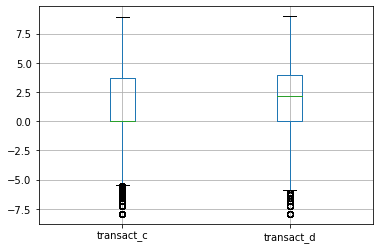

In [9]:
tmp = pd.concat(list(dict_rolled.values()))
tmp = np.log(tmp.replace({0: 1}))
tmp.boxplot()
tmp['transact_c'].min(), tmp['transact_c'].max(), tmp['transact_d'].min(), tmp['transact_d'].max()

In [10]:
bin_size = 0.6
bin_min, bin_max = -8, 8.9
bins = [bin_min + i * bin_size for i in range(int((bin_max - bin_min) / bin_size) + 1)]

def transacts_to_bins(transacts):
    transacts = np.log(transacts.replace({0: 1}))
    feat = np.zeros((len(bins)))
    tmp = np.digitize(transacts, bins) - 1
    tmp = pd.DataFrame(tmp).reset_index(drop=False).groupby(0).count()['index']
    feat[tmp.index] = tmp
    return feat

X = np.zeros((len(df_reg), len(bins) * 2))
for i, cid in tqdm(enumerate(df_reg['id'])):
    feat_c = transacts_to_bins(dict_rolled[cid]['transact_c'])
    feat_d = transacts_to_bins(dict_rolled[cid]['transact_d'])
    X[i, :] = np.concatenate([feat_c, feat_d])

0it [00:00, ?it/s]

In [11]:
X.sum(axis=0)

array([4.41000e+02, 7.54000e+02, 7.84000e+02, 3.50800e+03, 5.86900e+03,
       9.76600e+03, 1.43370e+04, 2.00710e+04, 2.02350e+04, 1.50310e+04,
       1.42580e+04, 1.70110e+04, 1.69070e+04, 9.38176e+05, 3.64360e+04,
       3.75630e+04, 6.78520e+04, 8.55750e+04, 1.39025e+05, 1.64298e+05,
       1.50199e+05, 1.23035e+05, 7.74900e+04, 4.22990e+04, 1.77000e+04,
       5.85300e+03, 1.52800e+03, 6.80000e+02, 7.10000e+01, 2.30000e+01,
       7.30000e+01, 5.20000e+01, 5.90000e+01, 8.40000e+01, 6.10000e+01,
       7.80000e+01, 3.76300e+03, 1.06700e+03, 4.53000e+02, 1.42600e+03,
       7.93700e+03, 7.80300e+03, 8.04341e+05, 4.13520e+04, 5.57070e+04,
       1.00452e+05, 1.37149e+05, 1.78599e+05, 2.06774e+05, 1.94838e+05,
       1.47183e+05, 8.16140e+04, 3.59320e+04, 1.36520e+04, 4.14300e+03,
       1.41300e+03, 6.69000e+02, 5.50000e+01])

### Modelling (SVM)

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    confusion_matrix, roc_curve, 
    precision_recall_fscore_support, plot_roc_curve, roc_auc_score
)

y = df_reg['is_affluent_cur']

X_train = X[train_idxs, :]
y_train = np.array(y)[train_idxs]
X_val = X[val_idxs, :]
y_val = np.array(y)[val_idxs]
X_test = X[test_idxs, :]
y_test = np.array(y)[test_idxs]

In [13]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [14]:
pred_probs = svm.predict_proba(X_val)

In [15]:
pred = (pred_probs[:, 0] < 0.955).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='weighted')
print(precision, recall, f1)
confusion_matrix(pred, y_val)

0.9200612064821582 0.4988888888888889 0.6302461339652871


array([[428,  18],
       [433,  21]])

0.5805414098097025

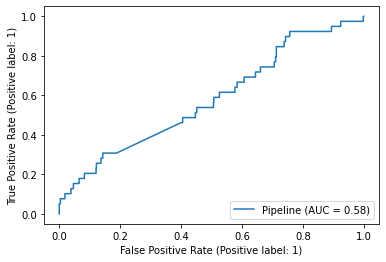

In [16]:
plot_roc_curve(svm, X_val, y_val)
roc_auc_score(y_val, pred_probs[:, 1])

Hyperparameters and result:

```
rolling_window = 28
bin_size = 1
bin_min, bin_max = -8, 9
auc = 0.60/0.60
```
```
rolling_window = 28
bin_size = 0.6
bin_min, bin_max = -8, 9
auc=0.58/0.66
```

In [17]:
tmp = pd.DataFrame(X)
tmp.insert(0, 'id', df_reg.reset_index()['id'])
tmp

,id,0,1,2,3,4,5,6,7,8,...,48,49,50,51,52,53,54,55,56,57
0,22366008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,76.0,35.0,18.0,59.0,14.0,0.0,0.0,0.0,0.0
1,22367033,0.0,0.0,0.0,28.0,0.0,28.0,39.0,28.0,0.0,...,20.0,30.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22369473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,194.0,87.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22372056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22382850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,142.0,65.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,17253418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,173.0,81.0,11.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
5990,26244841,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,28.0,48.0,17.0,9.0,27.0,0.0,0.0,0.0,0.0
5991,26249148,0.0,0.0,0.0,0.0,0.0,73.0,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5992,26250390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
